The WiDs Datathon 2023
- focuses on prediction task involving forecasting sub-seasonal temperatures (temperatures over a two-week period) within the US.
- dataset consisting of weather and climate information for a number of US locations, for a number of start dates for the two-week observation, for a number of weather forecast model. Each row in the data corresponds to a single location and a single start date for the two week period.
- the WiDS 2023 Datathon is using a subset of a pre-prepared dataset mentioned above
- variable naming: each variable name, prefix--suffix, consists of two parts informing the meaning of the variable. The prefix indicates from where the variable was derived. The suffix indicates the specific type of information that was extracted from the file

# Import libraries and data 

In [3]:
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [4]:
import warnings 
warnings.filterwarnings('ignore')

In [5]:
test = pd.read_csv('/kaggle/input/widsdatathon2023/test_data.csv')
train = pd.read_csv('/kaggle/input/widsdatathon2023/train_data.csv')

# Data preprocessing 

In [10]:
missing_col = [col for col in train.columns if train[col].isnull().any()]
missing_col

['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3',
 'ccsm30']

In [6]:
num_missingvalues = train.isna().sum()
missingvalues_df = pd.DataFrame(num_missingvalues[num_missingvalues != 0])
missingvalues_df.columns = ['Null Values Counts']
missingvalues_df

,Null Values Counts
nmme0-tmp2m-34w__ccsm30,15934
nmme-tmp2m-56w__ccsm3,10280
nmme-prate-34w__ccsm3,8738
nmme0-prate-56w__ccsm30,15934
nmme0-prate-34w__ccsm30,15934
nmme-prate-56w__ccsm3,10280
nmme-tmp2m-34w__ccsm3,8738
ccsm30,15934


In [7]:
train = train.dropna()

In [13]:
train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.00000,352604.000000,352604.000000,352604.000000,352604.000000,...,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000,352604.000000
mean,187865.647230,0.592766,0.517964,268.756935,10.008439,11.94841,9.914150,10.913216,10.131531,11.051802,...,-1.620554,-7.337988,4.057347,19.243644,-18.129475,-11.662332,-6.269694,14.722638,12.285321,12.662362
std,108465.230188,0.251744,0.272059,200.025342,10.741907,10.88407,10.336138,10.429579,9.321961,10.529236,...,37.866733,35.982786,36.453583,25.719270,32.513595,33.707956,27.444561,24.547827,24.244970,24.503133
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.97000,-11.720000,-17.560000,-13.720000,-13.330000,...,-94.570000,-89.940000,-64.870000,-39.280000,-100.560000,-106.080000,-93.980000,-52.610000,-66.110000,-54.580000
25%,93910.750000,0.409091,0.300000,95.620000,1.000000,3.06000,1.480000,2.560000,2.890000,2.480000,...,-27.360000,-31.800000,-20.220000,1.650000,-40.690000,-33.410000,-20.770000,-0.980000,-2.360000,-4.580000
50%,187866.500000,0.590909,0.533333,234.570000,8.860000,10.93000,9.150000,10.670000,9.990000,10.320000,...,-3.830000,-8.850000,0.135000,19.785000,-17.830000,-9.660000,-6.260000,18.490000,13.045000,12.675000
75%,281777.250000,0.818182,0.766667,412.950000,19.010000,20.91000,18.580000,19.410000,17.570000,19.150000,...,23.060000,18.230000,24.470000,36.090000,4.390000,9.280000,11.800000,30.370000,31.040000,30.240000
max,375733.000000,1.000000,1.000000,1185.140000,36.080000,36.03000,33.390000,34.310000,35.750000,38.350000,...,113.920000,96.550000,105.160000,91.760000,56.550000,83.890000,64.850000,77.960000,76.890000,88.660000


<AxesSubplot:>

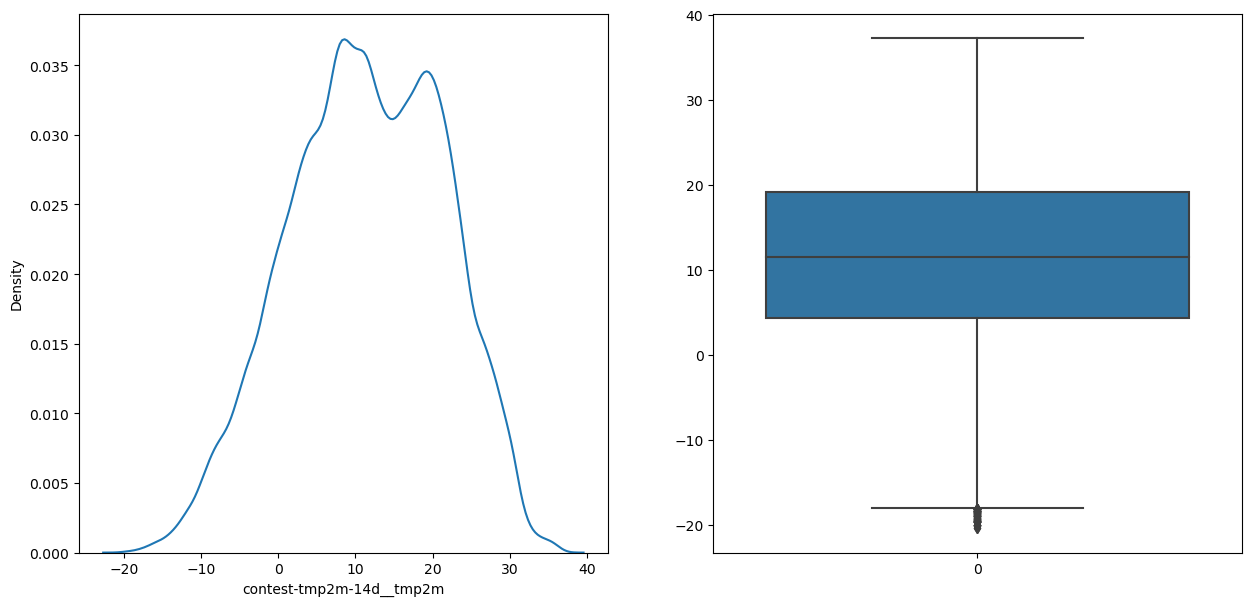

In [10]:
plt.figure(figsize = (15,7))
plt.subplot(121); sns.kdeplot (train['contest-tmp2m-14d__tmp2m'])
plt.subplot(122); sns.boxplot(train['contest-tmp2m-14d__tmp2m'])

In [15]:
def preprocessing(df):
    #converting the date column to a date object to perform date calculate
    df['startdate'] = pd.to_datetime(df['startdate'])
    
    #label encoding
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])

    #group by lat and lon, and by week 
    df_grp = df.groupby(['lat', 'lon', pd.Grouper(key='startdate', freq='W')]).mean()
    df_grp = df_grp.reset_index()
    
    #feature engineering the date column: turining it into an integer presentation
    earliest_date = pd.to_datetime('2014-09-01')
    df_grp['startdate_int'] = (df_grp['startdate'] - earliest_date).dt.days
    df_grp = df_grp.drop('startdate', axis=1)
       
    #divide the output (separate features and target)
    features, target = df_grp.drop('contest-tmp2m-14d__tmp2m', axis=1), df_grp['contest-tmp2m-14d__tmp2m']
    
    return features, target, df_grp


In [16]:
x_train, y_train, train_grp = preprocessing(train)

In [17]:

train_grp.head(2)

,lat,lon,index,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,startdate_int
0,0.0,0.833333,3.0,231.905714,29.02,31.64,29.57,30.73,29.71,31.52,...,-32.137143,9.320000,31.090000,-1.990000,53.338571,7.518571,-36.375714,19.708571,8.337143,6
1,0.0,0.833333,10.0,217.334286,29.02,31.64,29.57,30.73,29.71,31.52,...,-23.707143,64.875714,25.355714,-11.034286,59.180000,-22.625714,-34.265714,39.271429,2.928571,13


In [19]:
train_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50886 entries, 0 to 50885
Columns: 246 entries, lat to startdate_int
dtypes: float64(245), int64(1)
memory usage: 95.5 MB


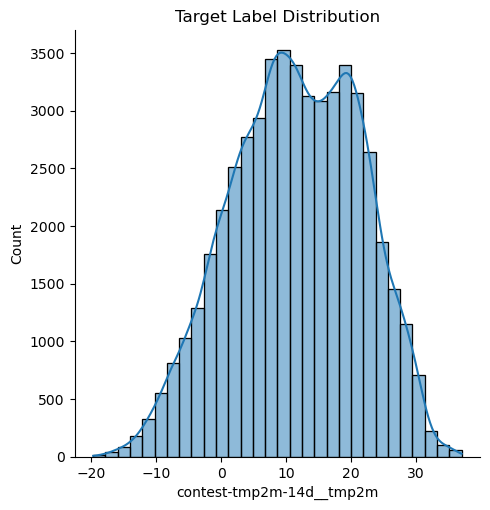

In [20]:
sns.displot(data = y_train, bins=30, kind='hist', kde=True).set(title='Target Label Distribution')
plt.show()

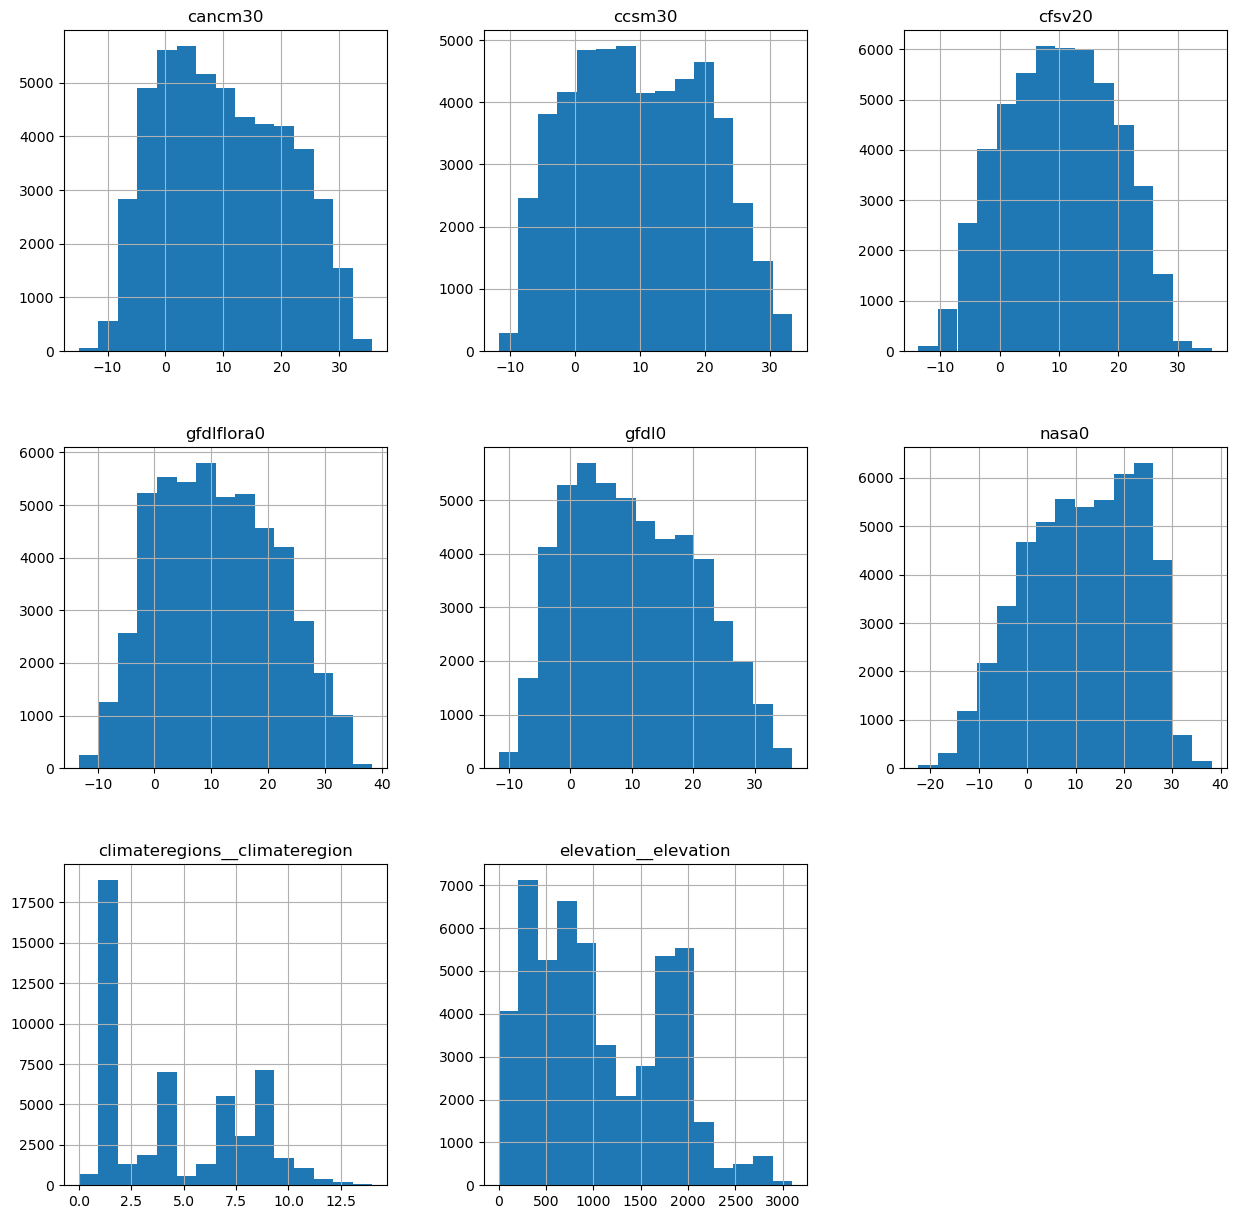

In [22]:
#plot some features
x_train[[ 'cancm30', 'ccsm30','cfsv20','gfdlflora0', 'gfdl0', 'nasa0', 
                    'climateregions__climateregion','elevation__elevation']].hist(bins=15, figsize=(15,15))
plt.show()

# Feature Selection

## Checking the correlation

In [18]:
corr = train_grp.corr().abs()



<AxesSubplot:>

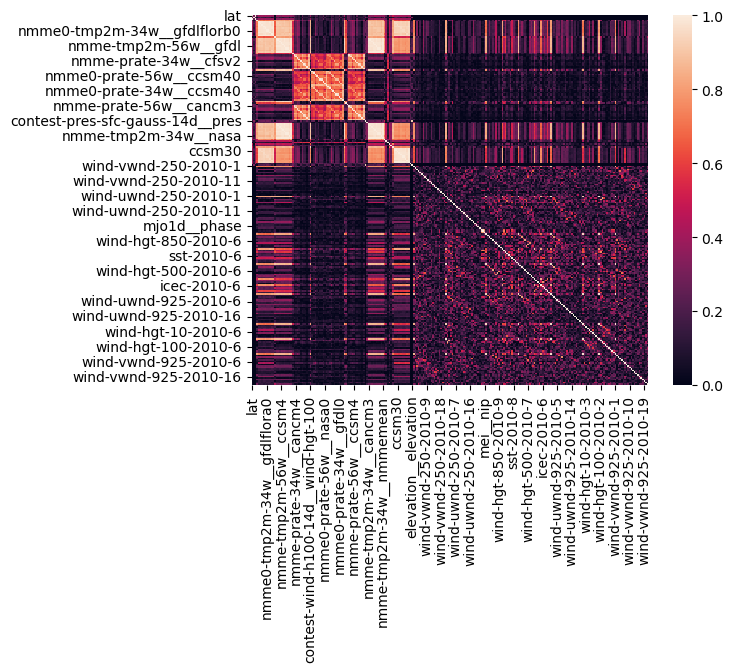

In [26]:
sns.heatmap(corr)

In [20]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [21]:
#get the column names to drop
to_drop = identify_correlated(x_train, threshold = .96)

In [22]:
x_train_reduced = pd.DataFrame(x_train.drop(to_drop, axis=1))

In [23]:
print(f'Number of features after dropping: {len(x_train_reduced.columns)}')
print(f'Number of dropped columns: {len(to_drop)}' )      

Number of features after dropping: 190
Number of dropped columns: 55


## Feature importance

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [25]:
pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())    
])




In [26]:
x_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50886 entries, 0 to 50885
Columns: 190 entries, lon to startdate_int
dtypes: float64(189), int64(1)
memory usage: 73.8 MB


In [27]:
x_train_red_sample = x_train_reduced.sample(1000)
y_train_sample = y_train.sample(1000)

In [28]:
x_train_red_sample

,lon,index,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,startdate_int
24469,0.333333,180672.0,19.437143,-1.231429,30506.617143,73.615714,16201.031429,15.240000,18.560000,22.200000,...,33.685714,34.964286,50.398571,-17.552857,-84.044286,34.797143,-2.644286,6.934286,1.160000,118
14881,0.933333,109870.0,265.085714,8.950000,30841.640000,76.280000,16348.364286,39.670000,52.550000,29.260000,...,25.510000,15.765714,43.200000,-44.820000,3.030000,-6.374286,4.717143,15.897143,40.521429,223
46283,0.166667,341729.5,409.806667,21.500000,31599.423333,56.070000,16532.385000,19.800000,4.030000,12.100000,...,-18.495000,23.270000,-20.261667,12.848333,25.420000,-73.466667,23.145000,-28.430000,3.580000,356
5559,0.366667,41044.0,135.132857,14.090000,30680.118571,49.437143,16295.684286,8.760000,6.520000,9.250000,...,14.710000,-34.402857,50.538571,-0.195714,-27.970000,32.230000,11.425714,7.334286,16.087143,111
31348,0.700000,231489.0,21.518571,-1.430000,30817.160000,81.138571,16064.382857,9.607143,9.604286,16.935714,...,70.851429,-14.104286,13.932857,17.225714,-79.451429,-4.920000,3.610000,-9.274286,20.774286,496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34515,0.833333,254874.0,13.211429,-1.130000,30769.140000,84.788571,16095.788571,7.050000,9.090000,15.380000,...,30.262857,-13.810000,9.144286,-20.090000,-47.355714,2.685714,-14.182857,25.988571,7.035714,489
23673,0.066667,174796.0,60.771429,6.490000,30673.857143,87.627143,16204.151429,8.500000,15.040000,20.250000,...,-33.172857,38.602857,-9.660000,7.624286,67.055714,-87.298571,32.890000,-14.470000,36.214286,90
25554,0.700000,188685.0,115.267143,3.210000,30558.320000,54.955714,16188.124286,10.950000,9.310000,26.100000,...,-33.172857,38.602857,-9.660000,7.624286,67.055714,-87.298571,32.890000,-14.470000,36.214286,90
47334,0.533333,349505.0,9.664286,-0.650000,30364.487143,84.571429,15997.898571,12.730000,7.000000,23.950000,...,-33.172857,38.602857,-9.660000,7.624286,67.055714,-87.298571,32.890000,-14.470000,36.214286,90


In [29]:
rf_model = pipeline.fit(x_train_red_sample, y_train_sample)


In [30]:
importances = rf_model.steps[1][1].feature_importances_

<BarContainer object of 190 artists>

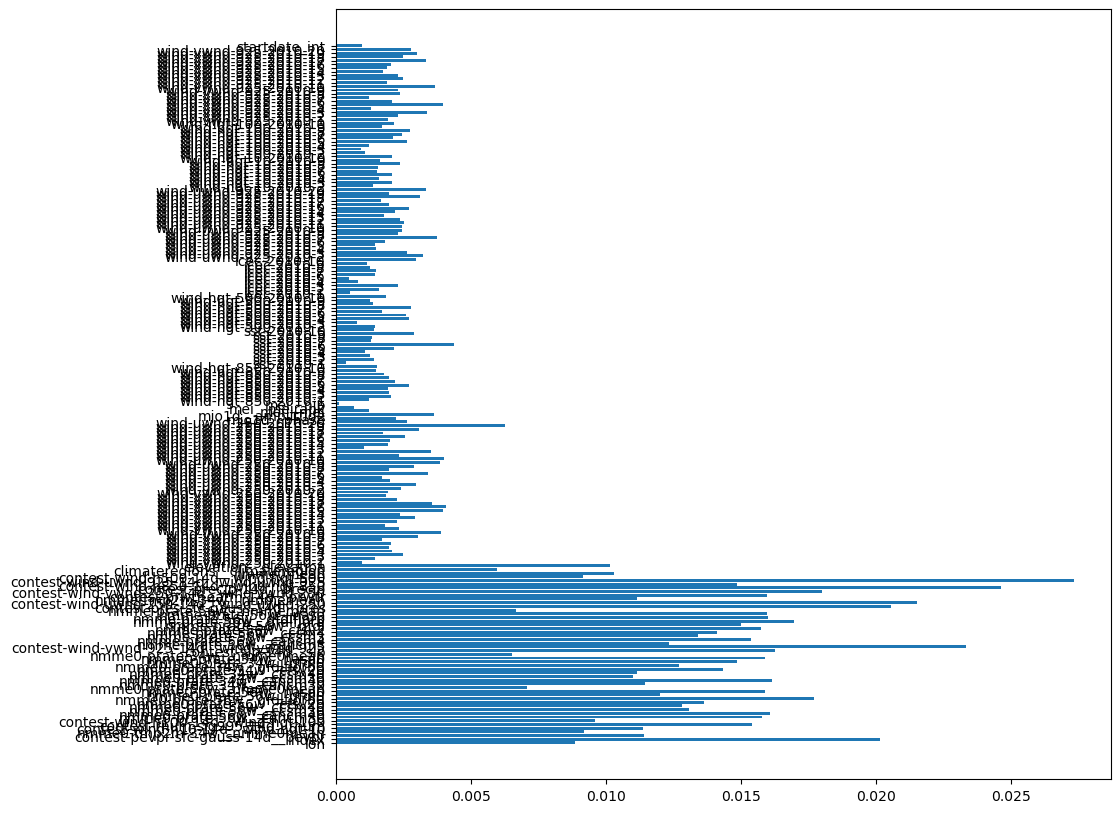

In [32]:
plt.figure(figsize=(10,10))
plt.barh(x_train_red_sample.columns, importances)

## Recursive Feature Extraction using Cross Validation (RFECV)
Pruning features utilizing feature importance scores. This technique also uses cross validation to help validate that the removal of features was not justified just by the sample taken

In [33]:
from sklearn.feature_selection import RFECV
estimator = RandomForestRegressor()
selector = RFECV(estimator, step=8, cv=3)


In [34]:
selector = selector.fit(x_train_red_sample, y_train_sample)

In [35]:
print('Feature ranking: ', selector.ranking_)


Feature ranking:  [ 3  1  1  3  1  1  1  1  1  1  1  1  1  1  1  4  1  1  2  1  1  1  1  1
  4  1  1  1  1  1  1  1  1  1  1  1  3  1  1  3  1  1  1  1  1  1  1  5
  2 18 19  8  6  8 11 17  7  5  4 10 17  6 11  1  5  4  7  6  7 14 12 11
 13 10 11  8  1  1  7  1 15  7 10  4 13  9  1  2  7  2 17 19 19 18  6 12
  8 15  8 18 12 14 16 19 18 15 17 14  2 15 17 10 13  9 19  4  9 11  4 12
 15  6 19 17 14 19 19 16 18 16 14  1  2 12  8  8 12  2  5  2  5  9 16 11
 15  5  9 16 13  9  6 18 16 17 13 14 15 12 14 14 18 17 13 10 11 12  7 10
  8 15  3  9 16  3 10 13 10 11  6  3  6  5  9 16 13  4  5  3  7 18]


In [36]:
#Get features marked as important by RFECV

mask = selector.get_support()
mask


array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [37]:
features = np.array(x_train_red_sample.columns)
best_features = features[mask]


In [38]:
x_train_import_ft = x_train_red_sample[best_features]


In [39]:
x_train_import_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 24469 to 21325
Data columns (total 46 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   index                                     1000 non-null   float64
 1   contest-pevpr-sfc-gauss-14d__pevpr        1000 non-null   float64
 2   contest-wind-h10-14d__wind-hgt-10         1000 non-null   float64
 3   contest-rhum-sig995-14d__rhum             1000 non-null   float64
 4   contest-wind-h100-14d__wind-hgt-100       1000 non-null   float64
 5   nmme0-prate-56w__cancm30                  1000 non-null   float64
 6   nmme0-prate-56w__cancm40                  1000 non-null   float64
 7   nmme0-prate-56w__ccsm30                   1000 non-null   float64
 8   nmme0-prate-56w__ccsm40                   1000 non-null   float64
 9   nmme0-prate-56w__cfsv20                   1000 non-null   float64
 10  nmme0-prate-56w__gfdlflorb0    

In [40]:
selected_col = list(x_train_import_ft.columns)


In [41]:
x_train_select = x_train[selected_col]

# Modeling

## Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
reg = LinearRegression().fit(x_train_select,y_train)

In [44]:
reg.score(x_train_select, y_train)

0.9632940505669101

The model gives a nice score!!!

In [45]:
# predicted result train
pred_train = reg.predict(x_train_select)

In [46]:
train_grp['pred_train'] = pred_train 

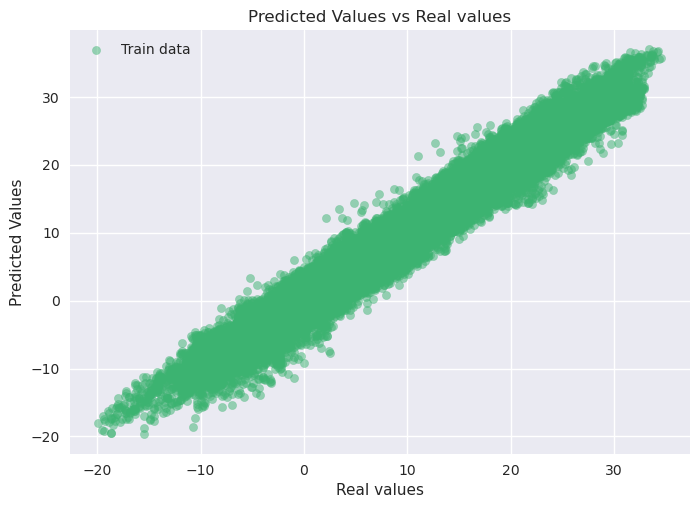

In [47]:
plt.style.use('seaborn')
plt.scatter(pred_train, y_train, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')


plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

# Applying the model to find target on test data

In [49]:
def preprocessing_test(df):
    #converting the date column to a date object to perform date calculate
    df['startdate'] = pd.to_datetime(df['startdate'])
    
    #label encoding
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])

    #group by lat and lon, and by week 
    df_grp = df.groupby(['lat', 'lon', pd.Grouper(key='startdate', freq='W')]).mean()
    df_grp = df_grp.reset_index()
    
    #feature engineering the date column: turining it into an integer presentation
    earliest_date = pd.to_datetime('2014-09-01')
    df_grp['startdate_int'] = (df_grp['startdate'] - earliest_date).dt.days
    df_grp = df_grp.drop('startdate', axis=1)
       
    return df_grp


In [50]:
preprocessing_test(test)

,lat,lon,index,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,startdate_int
0,0.0,0.833333,375736.5,347.615000,30.880000,30.920000,29.170000,31.020000,29.470000,30.930000,...,-49.116667,-20.083333,49.105000,-6.555000,19.123333,-25.553333,24.691667,-21.491667,15.493333,2988
1,0.0,0.833333,375743.0,348.252857,30.880000,30.920000,29.170000,31.020000,29.470000,30.930000,...,-56.098571,-9.931429,60.944286,-36.747143,17.462857,-18.998571,-3.264286,-8.302857,21.357143,2995
2,0.0,0.833333,375750.0,290.002857,30.880000,30.920000,29.170000,31.020000,29.470000,30.930000,...,-70.822857,4.091429,48.068571,-52.190000,9.164286,18.824286,-22.855714,10.514286,36.882857,3002
3,0.0,0.833333,375757.0,274.515714,28.208571,28.705714,28.584286,28.855714,27.655714,29.808571,...,-52.997143,36.918571,33.000000,-46.312857,6.390000,30.020000,-26.578571,10.152857,29.538571,3009
4,0.0,0.833333,375764.0,280.750000,27.140000,27.820000,28.350000,27.990000,26.930000,29.360000,...,-29.904286,27.601429,20.417143,-10.871429,7.810000,15.550000,-16.418571,-20.117143,15.330000,3016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621,1.0,0.866667,407057.0,194.968571,13.230000,16.760000,14.930000,17.560000,13.270000,15.950000,...,-29.904286,27.601429,20.417143,-10.871429,7.810000,15.550000,-16.418571,-20.117143,15.330000,3016
4622,1.0,0.866667,407064.0,154.107143,13.230000,16.760000,14.930000,17.560000,13.270000,15.950000,...,-8.560000,16.135714,12.572857,1.431429,0.188571,-14.197143,29.831429,-31.157143,4.612857,3023
4623,1.0,0.866667,407071.0,109.295714,13.230000,16.760000,14.930000,17.560000,13.270000,15.950000,...,-22.621429,66.618571,18.821429,-31.905714,1.237143,-57.335714,62.832857,-30.405714,-2.095714,3030
4624,1.0,0.866667,407078.0,54.037143,9.531429,13.310000,11.124286,14.354286,10.321429,12.722857,...,-22.010000,73.185714,53.671429,-8.650000,15.555714,-40.858571,27.505714,-16.042857,29.227143,3037


In [51]:
test_select = test[selected_col]

In [52]:
test_select.head()

,index,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,...,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,nmme0mean,wind-vwnd-250-2010-15,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-12,wind-uwnd-250-2010-19,icec-2010-10
0,375734,339.88,31233.02,72.04,16700.13,33.2,11.48,16.12,8.51,29.5,...,1549.82,-4.38,5916.86,30.77,-72.11,0.88,69.67,-110.97,99.96,0.13
1,375735,334.63,31230.63,71.93,16697.68,33.2,11.48,16.12,8.51,29.5,...,1550.55,-4.50,5917.85,30.77,-65.25,22.26,50.82,-90.62,89.95,0.13
2,375736,337.83,31225.26,72.43,16694.94,33.2,11.48,16.12,8.51,29.5,...,1550.16,-4.61,5918.56,30.77,-62.86,36.75,30.57,-79.12,82.30,0.13
3,375737,345.81,31220.87,71.88,16692.18,33.2,11.48,16.12,8.51,29.5,...,1550.15,-4.49,5920.30,30.77,-57.98,53.78,13.11,-68.04,78.45,0.13
4,375738,357.39,31214.54,71.18,16689.71,33.2,11.48,16.12,8.51,29.5,...,1551.19,-4.34,5923.03,30.77,-43.23,66.22,-4.37,-49.87,73.80,0.13


In [54]:
# predicting the target
pred_test = reg.predict(test_select)

In [55]:
pred_test

array([26.60693092, 26.55957592, 26.4829145 , ...,  6.48185581,
        7.44857366,  8.64539116])

In [56]:
from numpy import savetxt

In [57]:

savetxt('WiDs2023_result.csv', pred_test)